In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


from datetime import datetime, date

In [72]:
# Load the CSV file into a DataFrame
df = pd.read_csv("fraud_data.csv")

df['is_fraud'] = pd.to_numeric(df['is_fraud'], errors='coerce')

# This will be data I use to train the models
data = {
    "transaction_year": [],
    "transaction_month": [],
    "transaction_day": [],
    "transaction_hour": [],
    "transaction_minute": [],
    
    "age": [],
    
    "is_fraud": df['is_fraud'].values
}

# Parse the 'trans_date_trans_time' column and extract date components
for item in df['trans_date_trans_time']:
    parsed_date = datetime.strptime(item, "%d-%m-%Y %H:%M")
    data["transaction_year"].append(parsed_date.year)
    data["transaction_month"].append(parsed_date.month)
    data["transaction_day"].append(parsed_date.day)
    data["transaction_hour"].append(parsed_date.hour)
    data["transaction_minute"].append(parsed_date.minute)

# Parse the 'dob' column and extract date components
for item in df['dob']:
    parsed_date = datetime.strptime(item, "%d-%m-%Y")
    today = date.today()
    
    age = today.year - parsed_date.year - ((today.month, today.day) < (parsed_date.month, parsed_date.day))
    
    data["age"].append(age)

In [73]:
# 1. Compute the frequency of each merchant
merchant_counts = df['merchant'].value_counts()

"""
2. Most merchants appear too little to be able to give us information
on whether the specific merchant is correlated with fraud. I chose
30 because that is typically the smallest sample size used to get a
statistically significant result.
"""
merchants_less_than_30 = merchant_counts[merchant_counts < 30]
percentage_less_than_30 = (len(merchants_less_than_30) / len(merchant_counts)) * 100
print(f"Percentage of merchants that appear less than 30 times: {percentage_less_than_30:.2f}%")

# 3. Create a new column in df that maps the merchant frequency to each row.
df['merchant_freq'] = df['merchant'].map(merchant_counts)

# 4. Compute the correlation between merchant frequency and is_fraud
correlation = df[['merchant_freq', 'is_fraud']].corr()
print(correlation) # Weak correlation woooohooooo. Maybe will use it to create a weak learner?

# 5. Add to the data object
data['merchant_freq'] = df['merchant_freq'].values

Percentage of merchants that appear less than 30 times: 84.27%
               merchant_freq  is_fraud
merchant_freq       1.000000  0.121829
is_fraud            0.121829  1.000000


In [74]:
# WE CAN USE THE SPECIFIC CITY TO DETECT FRAUD BECAUSE THE COUNT IS OVER
# 30 FOR MOST OF THEM. HOWEVER, THAT SEEMS LIKE TOO MUCH RIGHT NOW NGL

# 1. Compute the frequency of each city
city_count = df['city'].value_counts()
state_count = df['state'].value_counts()
job_count = df['job'].value_counts()

# 2. Create a new column in df that maps cities to city frequency for each row.
df['city_freq'] = df['city'].map(city_count)
df['state_freq'] = df['state'].map(state_count)

# 3. Compute the correlation between merchant frequency and is_fraud
correlation = df[['city_freq', 'is_fraud']].corr()
print(correlation) # Weak negative correlation!!! Another weak learner!!

correlation = df[['state_freq', 'is_fraud']].corr()
print(correlation) # So weakly correlated it's useless.

# 4. Grab useful data
data['city_freq'] = df['city_freq'].values

           city_freq  is_fraud
city_freq   1.000000 -0.188793
is_fraud   -0.188793  1.000000
            state_freq  is_fraud
state_freq    1.000000 -0.015636
is_fraud     -0.015636  1.000000


In [75]:
data['city_pop'] = df['city_pop'].values
data['amt'] = df['amt'].values
data['lat'] = df['lat'].values
data['long'] = df['long'].values
data['merch_lat'] = df['merch_lat'].values
data['merch_long'] = df['merch_long'].values

data = pd.DataFrame(data)

# One hot encode cities
dummies = pd.get_dummies(df['state'], prefix='state').astype(int)
data = pd.concat([data, dummies], axis=1)

# One hot encode categories.
dummies = pd.get_dummies(df['category'], prefix='category').astype(int)
data = pd.concat([data, dummies], axis=1)

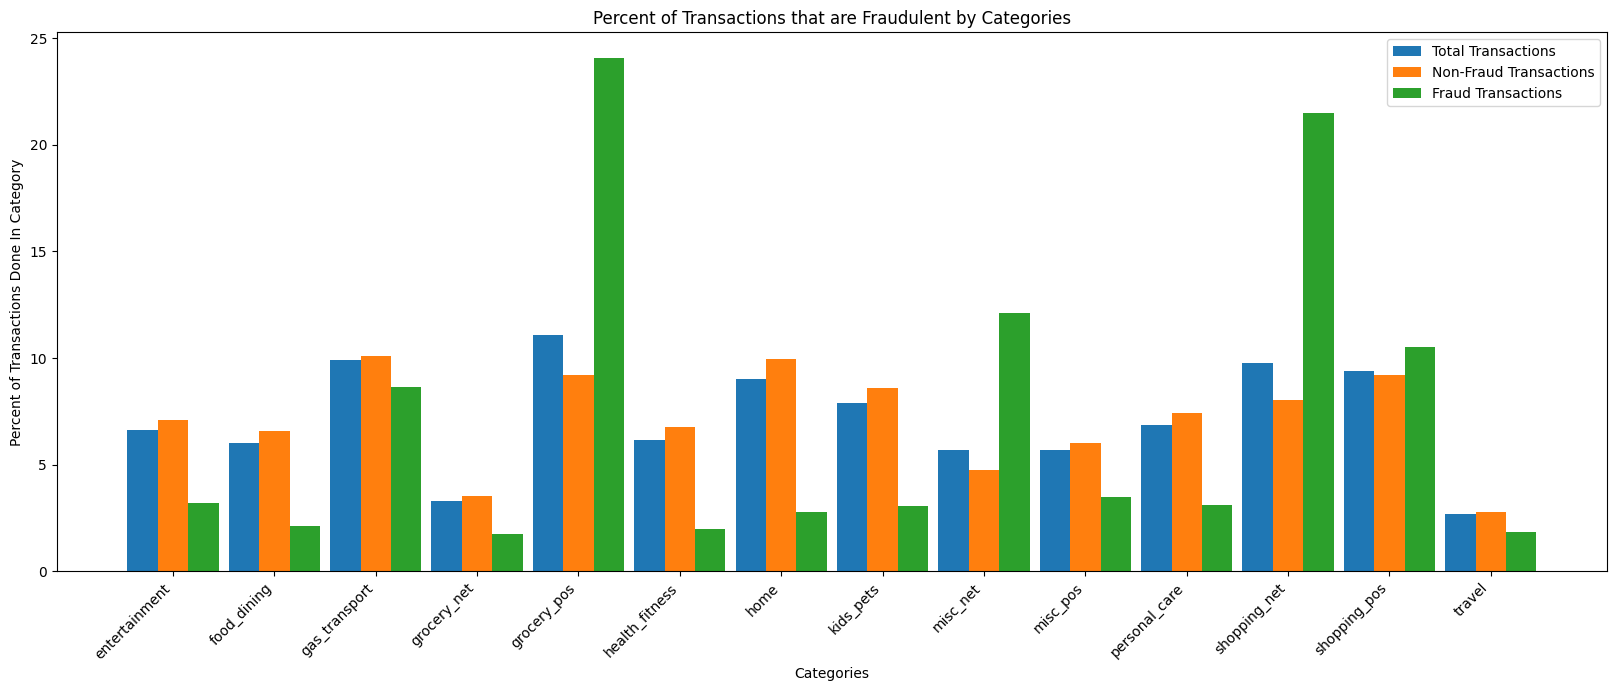

In [76]:
# Visauling Fraud by Categories
categories = df.groupby('category').size().reset_index(name='fraud_count')
nonfraud_by_categories = df[df['is_fraud'] == 0].groupby('category').size().reset_index(name='fraud_count')
fraud_by_categories = df[df['is_fraud'] == 1].groupby('category').size().reset_index(name='fraud_count')

categories['fraud_count'] = 100 * categories['fraud_count'] / categories['fraud_count'].sum()
nonfraud_by_categories['fraud_count'] = 100 * nonfraud_by_categories['fraud_count'] / nonfraud_by_categories['fraud_count'].sum()
fraud_by_categories['fraud_count'] = 100 * fraud_by_categories['fraud_count'] / fraud_by_categories['fraud_count'].sum()

# Merge data to ensure alignment across all categories
merged = categories.merge(nonfraud_by_categories, on='category', how='left', suffixes=('_total', '_nonfraud'))
merged = merged.merge(fraud_by_categories, on='category', how='left')
merged.rename(columns={'fraud_count': 'fraud_count_fraud'}, inplace=True)

# Set positions for bars
x = np.arange(len(merged['category']))  # Label locations
width = 0.3  # Width of bars

# Plot bars
plt.figure(figsize=(20, 7))
plt.bar(x - width, merged['fraud_count_total'], width=width, label='Total Transactions')
plt.bar(x, merged['fraud_count_nonfraud'], width=width, label='Non-Fraud Transactions')
plt.bar(x + width, merged['fraud_count_fraud'], width=width, label='Fraud Transactions')

# Labels and title
plt.xlabel('Categories')
plt.ylabel('Percent of Transactions Done In Category')
plt.title('Percent of Transactions that are Fraudulent by Categories')
plt.xticks(x, merged['category'], rotation=45, ha="right")  # Rotate category names for better visibility
plt.legend()
plt.show()

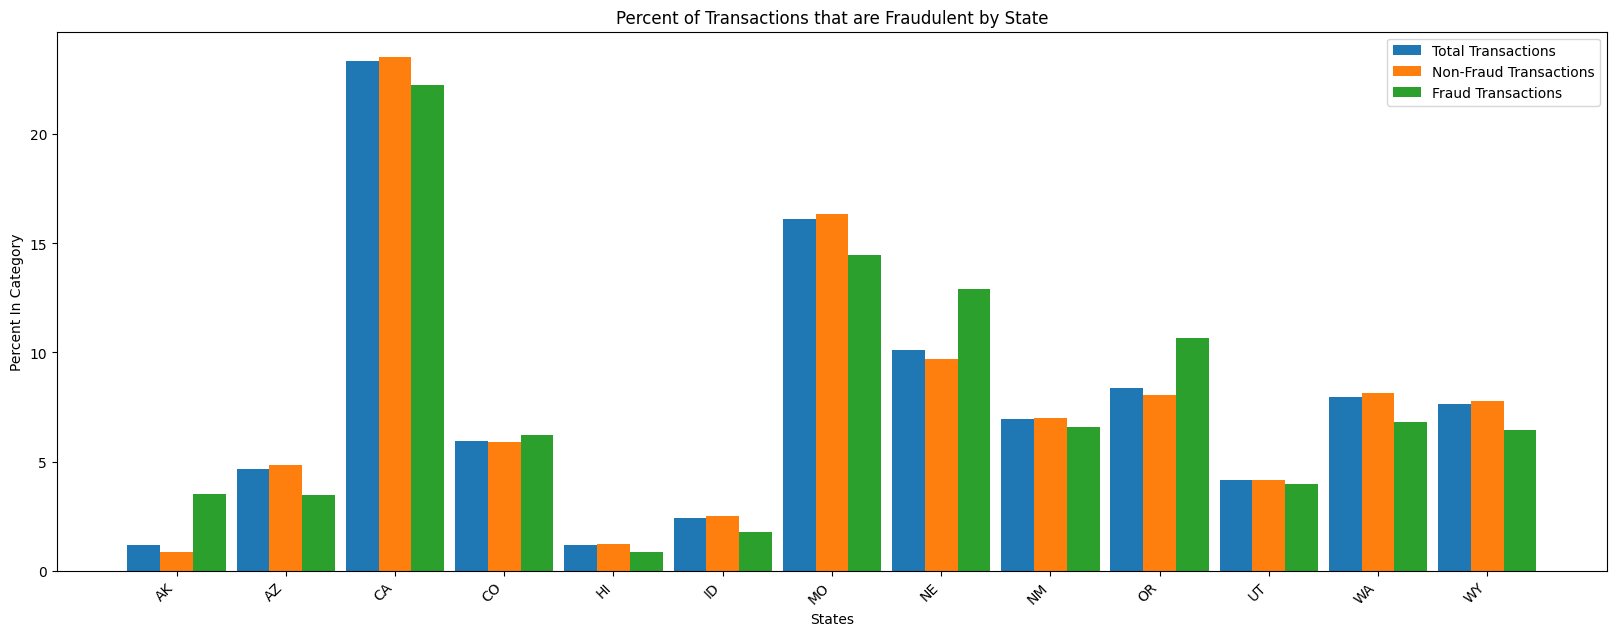

In [77]:
# Visauling Fraud by Categories
categories = df.groupby('state').size().reset_index(name='fraud_count')
nonfraud_by_categories = df[df['is_fraud'] == 0].groupby('state').size().reset_index(name='fraud_count')
fraud_by_categories = df[df['is_fraud'] == 1].groupby('state').size().reset_index(name='fraud_count')

categories['fraud_count'] = 100 * categories['fraud_count'] / categories['fraud_count'].sum()
nonfraud_by_categories['fraud_count'] = 100 * nonfraud_by_categories['fraud_count'] / nonfraud_by_categories['fraud_count'].sum()
fraud_by_categories['fraud_count'] = 100 * fraud_by_categories['fraud_count'] / fraud_by_categories['fraud_count'].sum()

# Merge data to ensure alignment across all categories
merged = categories.merge(nonfraud_by_categories, on='state', how='left', suffixes=('_total', '_nonfraud'))
merged = merged.merge(fraud_by_categories, on='state', how='left')
merged.rename(columns={'fraud_count': 'fraud_count_fraud'}, inplace=True)

# Set positions for bars
x = np.arange(len(merged['state']))  # Label locations
width = 0.3  # Width of bars

# Plot bars
plt.figure(figsize=(20, 7))
plt.bar(x - width, merged['fraud_count_total'], width=width, label='Total Transactions')
plt.bar(x, merged['fraud_count_nonfraud'], width=width, label='Non-Fraud Transactions')
plt.bar(x + width, merged['fraud_count_fraud'], width=width, label='Fraud Transactions')

# Labels and title
plt.xlabel('States')
plt.ylabel('Percent In Category')
plt.title('Percent of Transactions that are Fraudulent by State')
plt.xticks(x, merged['state'], rotation=45, ha="right")  # Rotate category names for better visibility
plt.legend()
plt.show()

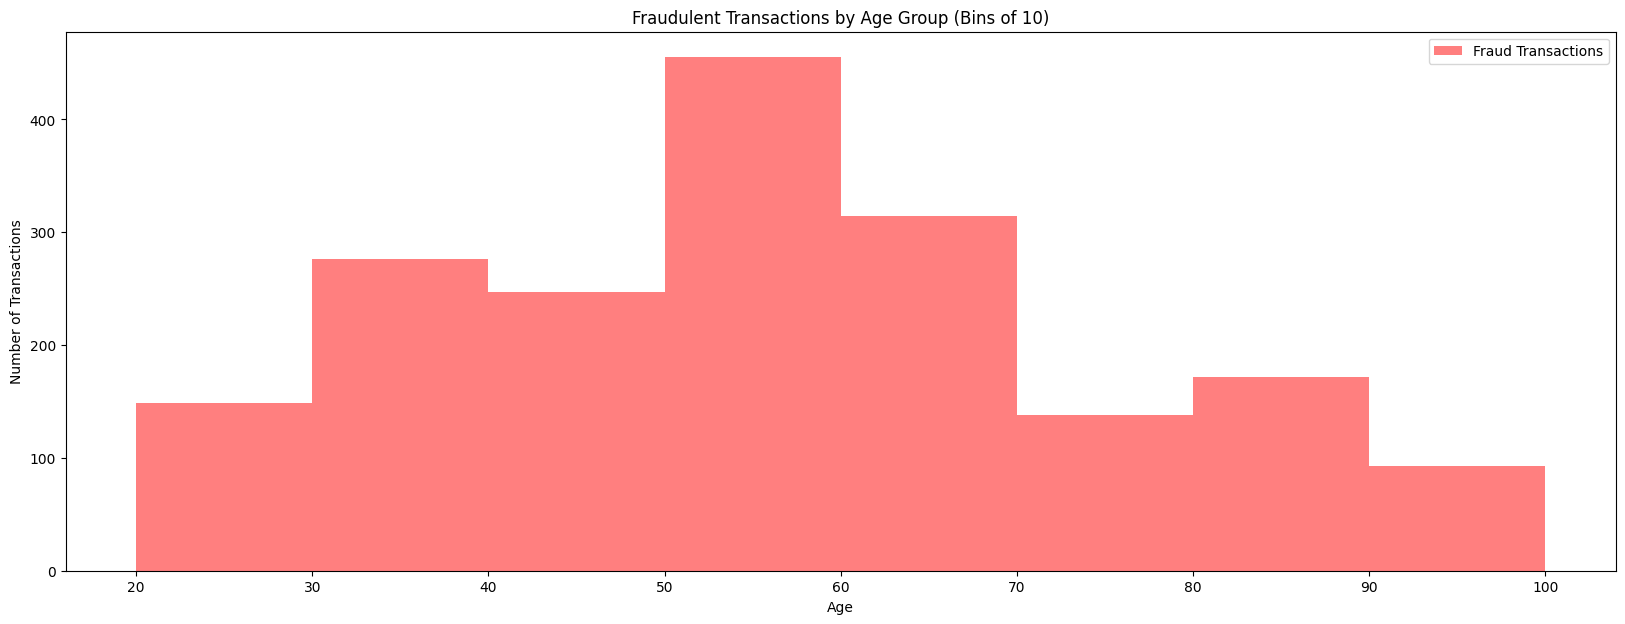

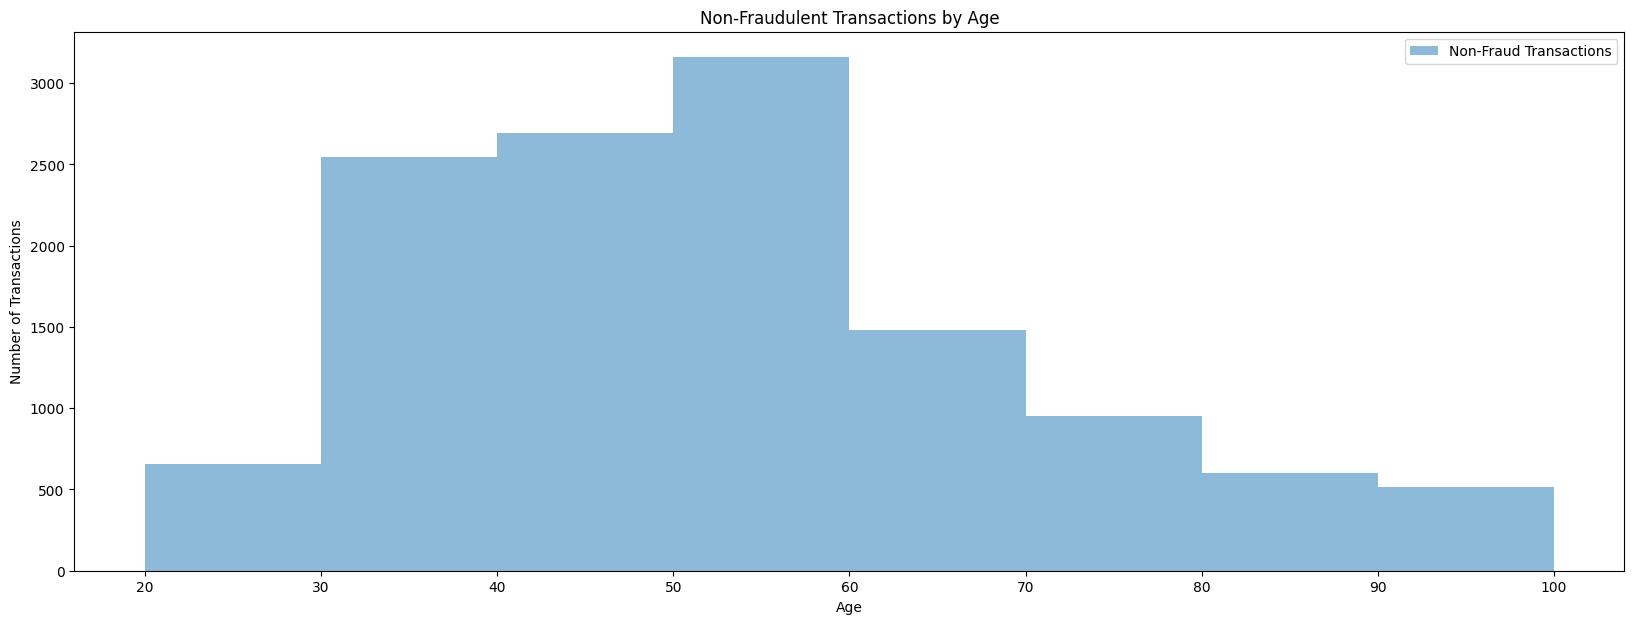

In [78]:
# Define the bins – groups of 10 years.
min_age = data['age'].min()
max_age = data['age'].max()
bins = np.arange(min_age - (min_age % 10), max_age + 10, 10)

# Create histograms for each group
plt.figure(figsize=(20, 7))
plt.hist(data[data['is_fraud'] == 1]['age'], bins=bins, alpha=0.5, label='Fraud Transactions', color='red')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Transactions')
plt.title('Fraudulent Transactions by Age Group (Bins of 10)')
plt.legend()
plt.show()

# Create histograms for each group
plt.figure(figsize=(20, 7))
plt.hist(data[data['is_fraud'] == 0]['age'], bins=bins, alpha=0.5, label='Non-Fraud Transactions')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Transactions')
plt.title('Non-Fraudulent Transactions by Age')
plt.legend()
plt.show()

In [79]:
data = data.dropna(subset=['is_fraud'])
data

,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_minute,age,is_fraud,merchant_freq,city_freq,city_pop,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,2019,1,4,0,58,85,1.0,11,111,145,...,0,0,0,0,0,0,0,0,0,0
1,2019,1,4,15,6,85,1.0,25,111,145,...,0,0,0,0,0,0,0,1,0,0
2,2019,1,4,22,37,85,1.0,15,111,145,...,0,0,0,0,0,1,0,0,0,0
3,2019,1,4,23,6,85,1.0,39,111,145,...,1,0,0,0,0,0,0,0,0,0
4,2019,1,4,23,59,85,1.0,27,111,145,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14441,2019,1,22,0,37,48,0.0,38,103,1302,...,0,0,0,0,0,0,0,0,1,0
14442,2019,1,22,0,41,68,0.0,20,95,260,...,0,0,0,0,0,1,0,0,0,0
14443,2019,1,22,0,42,51,0.0,35,59,110,...,1,0,0,0,0,0,0,0,0,0
14444,2019,1,22,0,48,85,0.0,27,111,145,...,0,0,0,0,0,0,0,0,1,0


In [80]:
scaler = StandardScaler()

X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
LogisticRegressionModel = LogisticRegression(max_iter=1000)
LogisticRegressionModel.fit(X_train_scaled, y_train)
y_pred = LogisticRegressionModel.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.943232952578747
Confusion Matrix:
 [[2479   23]
 [ 141  246]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2502
         1.0       0.91      0.64      0.75       387

    accuracy                           0.94      2889
   macro avg       0.93      0.81      0.86      2889
weighted avg       0.94      0.94      0.94      2889



In [82]:
RandomForestModel = RandomForestClassifier()
RandomForestModel.fit(X_train_scaled, y_train)
y_pred = RandomForestModel.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9993077189338871
Confusion Matrix:
 [[2500    2]
 [   0  387]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2502
         1.0       0.99      1.00      1.00       387

    accuracy                           1.00      2889
   macro avg       1.00      1.00      1.00      2889
weighted avg       1.00      1.00      1.00      2889



In [83]:
LinearRegressionModel = LinearRegression()
LinearRegressionModel.fit(X_train_scaled, y_train)
y_pred = LinearRegressionModel.predict(X_test_scaled)

print("=" * 50)
print("Model Performance Metrics")
print("=" * 50)

print(f"{'Mean Squared Error (MSE):':35s} {np.round(mean_squared_error(y_test, y_pred), 4)}")
print(f"{'Mean Absolute Error (MAE):':35s} {np.round(mean_absolute_error(y_test, y_pred), 4)}")
print(f"{'R² Score:':35s} {np.round(r2_score(y_test, y_pred), 4)}")

print("=" * 50)

Model Performance Metrics
Mean Squared Error (MSE):           0.0609
Mean Absolute Error (MAE):          0.1397
R² Score:                           0.475


In [84]:
DecisionStumpModel = DecisionTreeClassifier(max_depth = 1)
DecisionStumpModel.fit(X_train, y_train)
y_pred = DecisionStumpModel.predict(X_test)

print("="*50)
print("Decision Stump Results")
print("="*50)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}\n")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

Decision Stump Results
Accuracy Score: 0.9463

Confusion Matrix:
[[2439   63]
 [  92  295]] 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2502
         1.0       0.82      0.76      0.79       387

    accuracy                           0.95      2889
   macro avg       0.89      0.87      0.88      2889
weighted avg       0.94      0.95      0.95      2889



In [85]:
GradientBoostingModel = GradientBoostingClassifier()
GradientBoostingModel.fit(X_train, y_train)
y_pred = GradientBoostingModel.predict(X_test)

print("="*50)
print("Gradient Boosting Classifier Results")
print("="*50)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}\n")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

Gradient Boosting Classifier Results
Accuracy Score: 0.9979

Confusion Matrix:
[[2501    1]
 [   5  382]] 

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2502
         1.0       1.00      0.99      0.99       387

    accuracy                           1.00      2889
   macro avg       1.00      0.99      1.00      2889
weighted avg       1.00      1.00      1.00      2889

